In [ ]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# packages for cnn model
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

Preprocessing of the Data

In [ ]:
import os

base_dir = os.path.dirname(os.path.abspath(__file__))
train_directory = os.path.join(base_dir, "EmotionsData", "train")
test_directory  = os.path.join(base_dir, "EmotionsData", "test")

# create ImageDataGenerator for train and test splits
traindata_gen = ImageDataGenerator(rescale = 1./255,
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   rotation_range = 10,
                                   shear_range = 0.1,
                                   validation_split = 0.25,
                                   fill_mode='nearest')

testdata_gen = ImageDataGenerator(rescale=1./255)

# training dataset
train_dataset = traindata_gen.flow_from_directory(
    train_directory,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# validation dataset
validation_dataset = traindata_gen.flow_from_directory(
    test_directory,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

# testing dataset
test_dataset = testdata_gen.flow_from_directory(
    test_directory,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 21535 images belonging to 7 classes.
Found 1791 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# train image labels
train_labels = {value: key for key, value in train_dataset.class_indices.items()}
len(train_labels)

7

In [ ]:
# validation image labels
validation_labels = {value: key for key, value in validation_dataset.class_indices.items()}
len(train_labels)

7

In [ ]:
# test image labels
test_labels = {value: key for key, value in test_dataset.class_indices.items()}
len(test_labels)

7

In [ ]:
labels = list(train_labels.values())
print(labels)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


View a sample of the training images

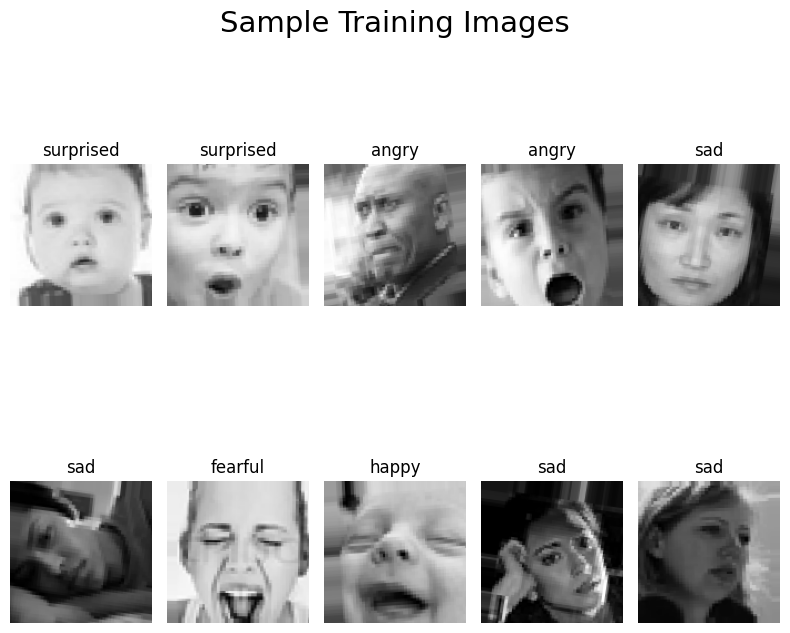

In [ ]:
# view sample training images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8, 8))
idx = 0

for i in range(2):
    for j in range(5):
        label = train_labels[np.argmax(train_dataset[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_dataset[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Counts for number of images in each emotion for the training dataset

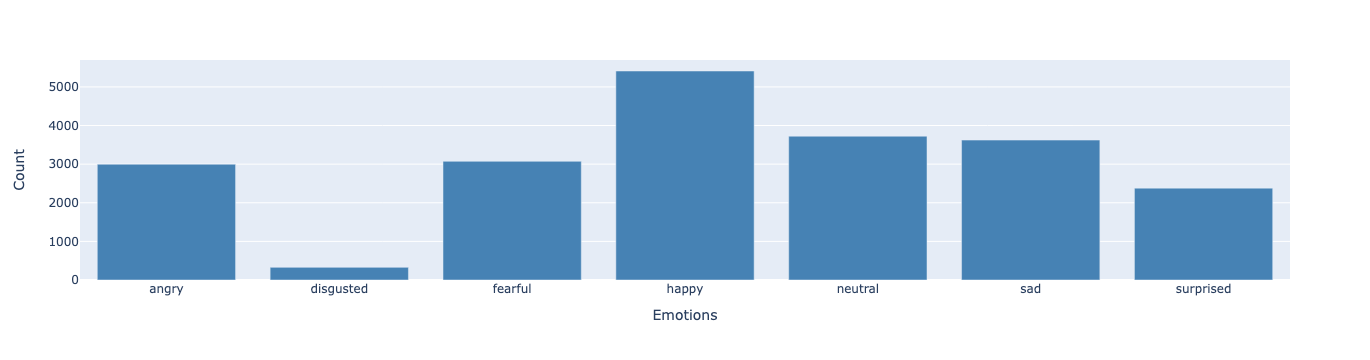

In [ ]:
#Counts for each category in training dataset
fig = px.bar(
    x=labels,
    y=[list(train_dataset.classes).count(i) for i in np.unique(train_dataset.classes)]
)
fig.update_traces(marker_color='SteelBlue')
fig.update_xaxes(title_text='Emotions')
fig.update_yaxes(title_text='Count')
fig.show()

Create the Baseline Model

In [ ]:
# create baseline model
base_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape= (128,128,3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    ##
                                    tf.keras.layers.Flatten(),
                                    ##
                                    tf.keras.layers.Dense(units = 64, activation = 'relu'),
                                    ##
                                    tf.keras.layers.Dense(units = 7, activation = 'softmax')
                                    ])
base_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,919 (3.15 MB)

 Trainable params: 826,919 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile model
base_model.compile(optimizer = Adam(learning_rate=0.001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])

# fit using training data
base_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3)
base_early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

base_history = base_model.fit(train_dataset, epochs=10, validation_data=validation_dataset,
                       verbose=1,
                       callbacks=[base_early_stop, base_reduce_lr])

Epoch 1/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.2425 - loss: 1.8166 - val_accuracy: 0.2965 - val_loss: 1.7509 - learning_rate: 0.0010
Epoch 2/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.2625 - loss: 1.8273 - val_accuracy: 0.3238 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 3/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.3074 - loss: 1.7699 - val_accuracy: 0.3227 - val_loss: 2.0425 - learning_rate: 0.0010
Epoch 4/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.3107 - loss: 1.8911 - val_accuracy: 0.3171 - val_loss: 2.0825 - learning_rate: 0.0010
Epoch 5/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.2939 - loss: 2.6826 - val_accuracy: 0.2272 - val_loss: 4.2395 - learning_rate: 0.0010
Epoch 6/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.2836 - loss: 4.8067 - val_accuracy: 0.2663 - val_loss: 6.6545 - learning_rate: 3.1623e-04
Epoch 7/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.2708

Evaluation of the Baseline Model

In [ ]:
# model metrics
base_train_accuracy = base_history.history['accuracy']
base_val_accuracy = base_history.history['val_accuracy']

base_train_loss = base_history.history['loss']
base_val_loss = base_history.history['val_loss']

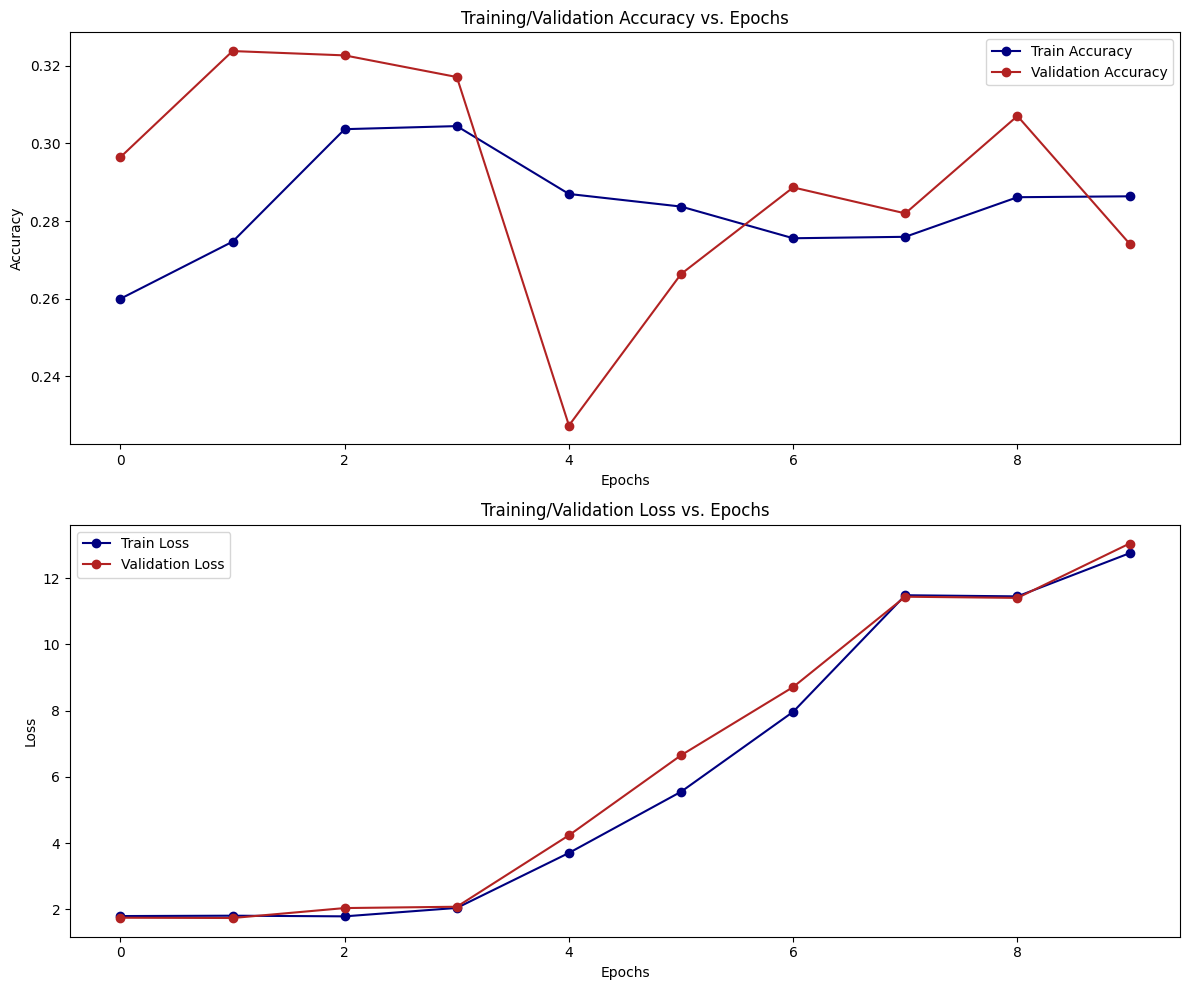

In [ ]:
# plot training/validation accuracy and loss throughout training process
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training/Validation Accuracy vs. Epochs')
ax[0].plot(base_train_accuracy, 'o-', color='navy', label='Train Accuracy')
ax[0].plot(base_val_accuracy, 'o-', color='FireBrick',label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(base_train_loss, 'o-', color='navy',label='Train Loss')
ax[1].plot(base_val_loss, 'o-', color='FireBrick', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


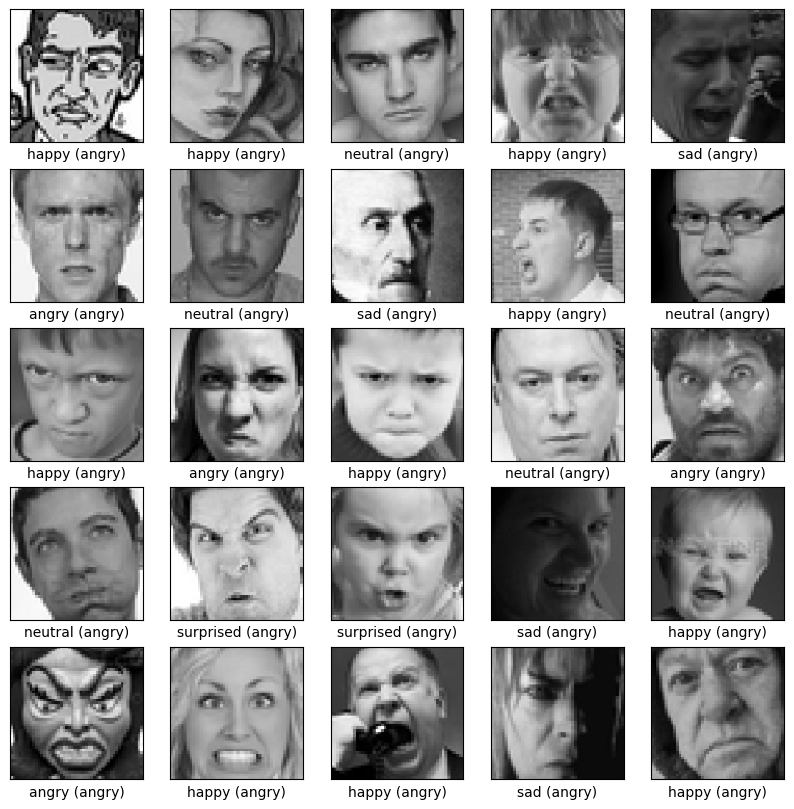

In [ ]:
# sample test images with predicted (and true labels)
img, labels_batch = test_dataset[108]
pred = base_model.predict(img)
predicted_classes = np.argmax(pred, axis=1)
true_class = np.argmax(labels_batch, axis=1)
emotionLabels = list(test_dataset.class_indices.keys())

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    plt.xlabel(emotionLabels[predicted_classes[i]] + f" ({emotionLabels[true_class[i]]})")
plt.show()

Implementation of More Complex CNN Model Architecture

In [ ]:
# create more complex cnn model architecture
# utilizing more layers, kernel regularizer, batch normalization, dropout
model = tf.keras.models.Sequential([
                                    # first convolutional layer
                                    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu',
                                                           padding = 'same', kernel_regularizer = l2(0.00002), input_shape=(128,128,3)),
                                    BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),


                                    # second convolutional layer
                                    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                                                           padding = 'same', kernel_regularizer = l2(0.00001)),
                                    BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),


                                    # third convolutional layer
                                    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu',
                                                           padding = 'same', kernel_regularizer = l2(0.00001)),
                                    BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),


                                    # fourth convolutional layer
                                    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu',
                                                           padding = 'same', kernel_regularizer = l2(0.00001)),
                                    BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),


                                    # fifth convolutional layer
                                    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu',
                                                           padding = 'same', kernel_regularizer = l2(0.00001)),
                                    BatchNormalization(),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),


                                    # flatten before passing to fully connected layers
                                    tf.keras.layers.Flatten(),

                                    # fully connected / dense layers
                                    tf.keras.layers.Dense(units = 256, activation= 'relu', kernel_regularizer = l2(0.00001)),
                                    tf.keras.layers.Dropout(0.4),
                                    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_regularizer = l2(0.00001)),
                                    tf.keras.layers.Dropout(0.4),

                                    # output classes
                                    tf.keras.layers.Dense(7, activation= 'softmax')
                                    ])

In [ ]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,477,223 (5.64 MB)

 Trainable params: 1,476,231 (5.63 MB)

 Non-trainable params: 992 (3.88 KB)

None


Compiling and Fitting of the More Advanced Model

In [ ]:
# compile model
model.compile(optimizer= Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# fit using training data
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model.fit(train_dataset,
                    epochs=60,
                    validation_data=validation_dataset,
                    verbose=1,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 67s 93ms/step - accuracy: 0.1915 - loss: 23.8167 - val_accuracy: 0.2691 - val_loss: 4.7738 - learning_rate: 0.0010
Epoch 2/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.2024 - loss: 4.6281 - val_accuracy: 0.2496 - val_loss: 2.5039 - learning_rate: 0.0010
Epoch 3/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.2146 - loss: 2.6729 - val_accuracy: 0.3037 - val_loss: 2.1451 - learning_rate: 0.0010
Epoch 4/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.2487 - loss: 2.2385 - val_accuracy: 0.3238 - val_loss: 2.0960 - learning_rate: 0.0010
Epoch 5/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.2530 - loss: 2.1571 - val_accuracy: 0.1742 - val_loss: 2.6511 - learning_rate: 0.0010
Epoch 6/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.3084 - loss: 2.0146 - val_accuracy: 0.3065 - val_loss: 1.8573 - learning_rate: 0.0010
Epoch 7/60
673/673 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.3516 - 

Evaluation of the More Complex Model

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_dataset, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

train_loss, train_accuracy = model.evaluate(train_dataset, verbose=1)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6198 - loss: 1.0419
Validation Accuracy: 61.75%
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5522 - loss: 1.1983
Test Accuracy: 61.26%
673/673 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.6421 - loss: 0.9809
Train Accuracy: 63.85%


In [ ]:
# model metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

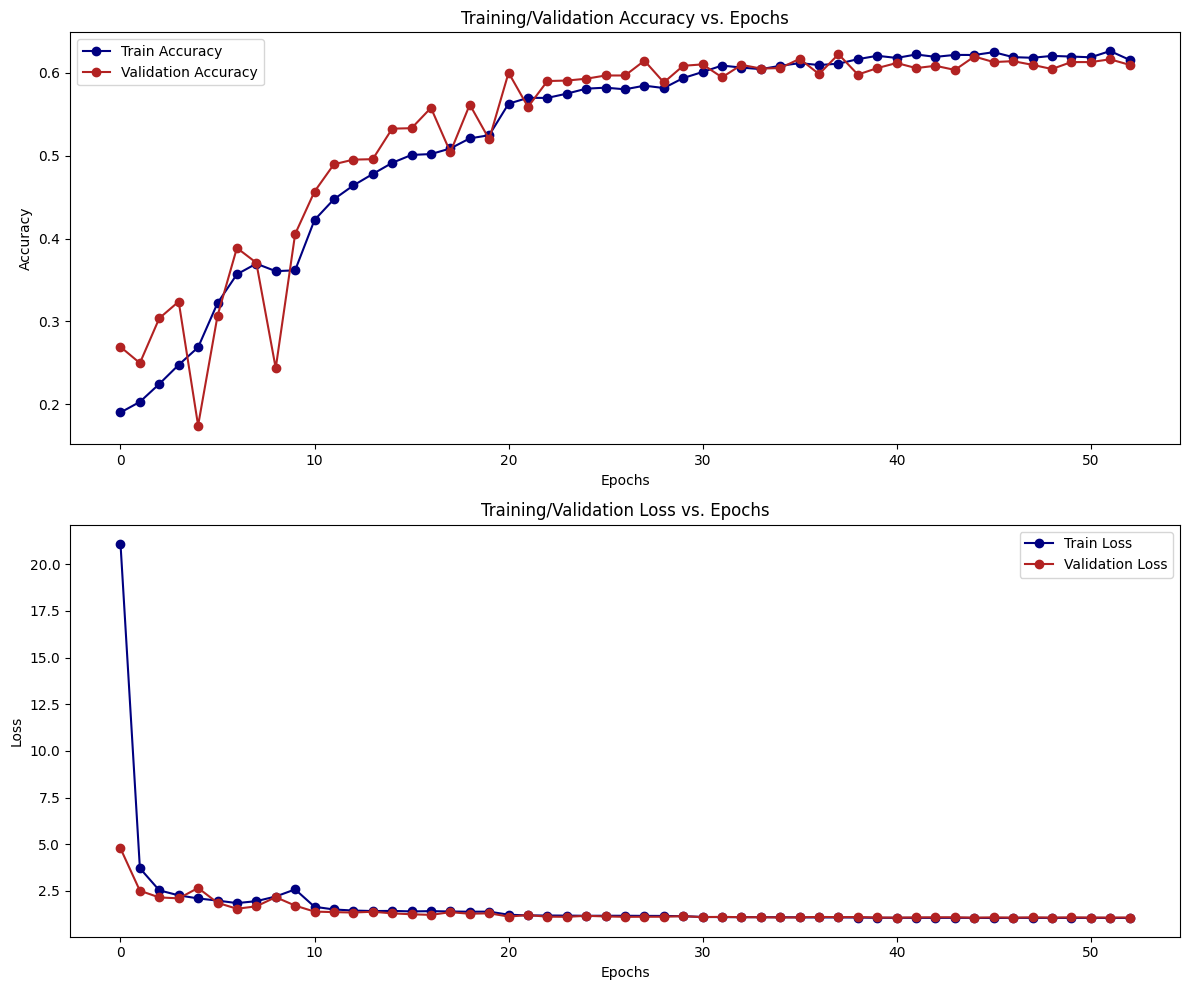

In [ ]:
# plot training/validation accuracy and loss throughout training process
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training/Validation Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', color='navy', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', color='FireBrick', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', color='navy',label='Train Loss')
ax[1].plot(val_loss, 'o-', color='FireBrick',label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.53      0.54       958
   disgusted       0.73      0.24      0.36       111
     fearful       0.43      0.27      0.34      1024
       happy       0.83      0.87      0.85      1774
     neutral       0.50      0.69      0.58      1233
         sad       0.48      0.47      0.47      1247
   surprised       0.78      0.73      0.76       831

    accuracy                           0.61      7178
   macro avg       0.61      0.54      0.56      7178
weighted avg       0.61      0.61      0.60      7178



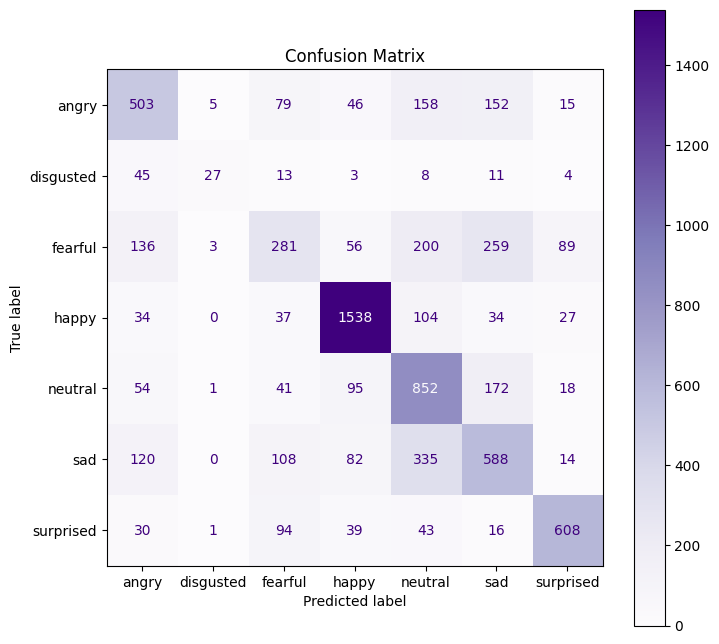

In [ ]:
pred = model.predict(test_dataset)
predicted_classes = np.argmax(pred, axis=1)
true_class = test_dataset.classes

emotionLabels = list(test_dataset.class_indices.keys())
class_report = classification_report(true_class, predicted_classes, target_names=emotionLabels)
print("Classification Report:")
print(class_report)

confusion_mat = confusion_matrix(true_class, predicted_classes)
matrix_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=emotionLabels)
fig, ax = plt.subplots(figsize=(8, 8))
matrix_plot.plot(cmap=plt.cm.Purples, ax=ax)
plt.title("Confusion Matrix")
plt.show()

In [1]:
img, labels_batch = test_dataset[108]
pred = model.predict(img)
predicted_classes = np.argmax(pred, axis=1)
true_class = np.argmax(labels_batch, axis=1)
emotionLabels = list(test_dataset.class_indices.keys())

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    plt.xlabel(emotionLabels[predicted_classes[i]] + f" ({emotionLabels[true_class[i]]})")
plt.show()

NameError: name 'test_dataset' is not defined